# Exoplanet Classifier — Training & Evaluation Report

This notebook loads your **trained artifacts** (`artifacts/`), evaluates the model on a dataset (e.g. `data/cleaned/KOI_clean_for_learning.csv`), and produces key plots:

- Metrics summary (ROC-AUC, PR-AUC, confusion matrix)
- Class balance
- ROC & PR curves
- P–Rₚ portrait (Period vs Radius) colored by **true** and **predicted** classes
- Boxplots of key features per class

> **Note:** The notebook assumes the repository layout from your project (`CCKJAV-`). Adjust the `BASE` path below if needed.


In [15]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import load
from sklearn.metrics import (
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# ---- Configure paths ----
# Set this to your project root if running elsewhere:
BASE = Path.cwd().parents[0]
ART  = BASE / "artifacts"
DATA = BASE / "data" / "cleaned" / "KOI_clean_for_learning.csv"  # change if needed

print("Using BASE =", BASE)
print("Artifacts path =", ART)
print("Data CSV =", DATA)

assert ART.exists(), f"Artifacts dir not found: {ART}"
assert (ART / "model.joblib").exists(), "model.joblib not found"
assert (ART / "label_encoder.joblib").exists(), "label_encoder.joblib not found"
assert (ART / "features.json").exists(), "features.json not found"


Using BASE = c:\Users\HOME\Desktop\NASA1\CCKJAV-
Artifacts path = c:\Users\HOME\Desktop\NASA1\CCKJAV-\artifacts
Data CSV = c:\Users\HOME\Desktop\NASA1\CCKJAV-\data\cleaned\KOI_clean_for_learning.csv


In [16]:
# Load artifacts
model = load(ART / "model.joblib")
label_enc = load(ART / "label_encoder.joblib")
features = json.loads((ART / "features.json").read_text(encoding="utf-8"))

# Metrics (if present)
metrics_path = ART / "metrics.json"
if metrics_path.exists():
    metrics = json.loads(metrics_path.read_text(encoding="utf-8"))
    print("Loaded metrics.json")
    print("Classes:", metrics.get("classes"))
    print("Saved ROC-AUC:", metrics.get("roc_auc") or metrics.get("roc_auc_ovr"))
else:
    metrics = {}
    print("metrics.json not found — will compute fresh metrics below.")


Loaded metrics.json
Classes: ['FALSE POSITIVE', 'PLANET']
Saved ROC-AUC: 0.9974006311408801


In [17]:
updated = metrics.copy()
updated["roc_auc_ovr"] = float(roc_auc)
updated["pr_auc"] = float(pr_auc)
(ART / "metrics.json").write_text(json.dumps(updated, indent=2), encoding="utf-8")
print("Saved updated metrics.json with ROC-AUC and PR-AUC.")

Saved updated metrics.json with ROC-AUC and PR-AUC.


In [4]:
# Load dataset
df = pd.read_csv(DATA)

# Try to detect the label column
LABEL_CANDIDATES = ["label", "koi_disposition", "tfopwg_disp", "pred_class"]
label_col = next((c for c in LABEL_CANDIDATES if c in df.columns), None)
if label_col is None:
    print("⚠️ No label column in data — plots using true labels will be skipped.")
else:
    print("Using label column:", label_col)

# Ensure required MODEL features exist; if not, derive from RAW8 via mapping.add_model_features
if not set(features).issubset(df.columns):
    print("MODEL features missing in CSV — deriving from RAW8 via mapping.add_model_features ...")
    try:
        # Try absolute import first (when running from repo root)
        from ml.mapping import add_model_features
    except Exception:
        # If notebook is placed inside ml/ directory
        from mapping import add_model_features
    RAW8 = ["koi_period","koi_duration","koi_depth","koi_prad",
            "koi_steff","koi_slogg","koi_srad","koi_kepmag"]
    missing_raw = [c for c in RAW8 if c not in df.columns]
    if missing_raw:
        raise KeyError(f"RAW8 columns missing; cannot derive MODEL features: {missing_raw}")
    derived = add_model_features(df[RAW8])
    for c in features:
        if c in derived.columns:
            df[c] = derived[c]

# Prepare X / y
X = df[features].astype(float).copy()
for c in X.columns:
    if X[c].isna().any():
        X[c] = X[c].fillna(0.0)

if label_col is not None:
    y_true_raw = df[label_col].astype(str).str.upper().str.strip().replace({"CONFIRMED":"PLANET"})
    mask = y_true_raw.isin(["PLANET", "FALSE POSITIVE"])
    y_true = (y_true_raw == "PLANET").astype(int)
    print("Labeled rows:", int(mask.sum()), "/", len(df))
else:
    y_true, mask = None, None


Using label column: koi_disposition
Labeled rows: 7584 / 9563


In [5]:
# Predictions
proba = model.predict_proba(X.values)
classes = list(label_enc.classes_)
pos_idx = classes.index("PLANET") if "PLANET" in classes else 1
y_score = proba[:, pos_idx]
y_pred = (y_score >= 0.5).astype(int)

print("Model classes:", classes)

# Metrics (if labels available)
if y_true is not None:
    try:
        roc_auc = roc_auc_score(y_true[mask], y_score[mask])
        pr_auc  = average_precision_score(y_true[mask], y_score[mask])
        cm = confusion_matrix(y_true[mask], y_pred[mask])
        print(f"ROC-AUC: {roc_auc:.4f}   PR-AUC: {pr_auc:.4f}")
        print("Confusion matrix:\n", cm)
        print("\nClassification report:\n", classification_report(y_true[mask], y_pred[mask], target_names=["FALSE POSITIVE","PLANET"]))        
    except Exception as e:
        print("Could not compute metrics:", e)
else:
    print("No labels — skipping metrics computation.")


Model classes: ['FALSE POSITIVE', 'PLANET']
ROC-AUC: 0.9974   PR-AUC: 0.9953
Confusion matrix:
 [[4768   70]
 [  67 2679]]

Classification report:
                 precision    recall  f1-score   support

FALSE POSITIVE       0.99      0.99      0.99      4838
        PLANET       0.97      0.98      0.98      2746

      accuracy                           0.98      7584
     macro avg       0.98      0.98      0.98      7584
  weighted avg       0.98      0.98      0.98      7584



c:\Users\HOME\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


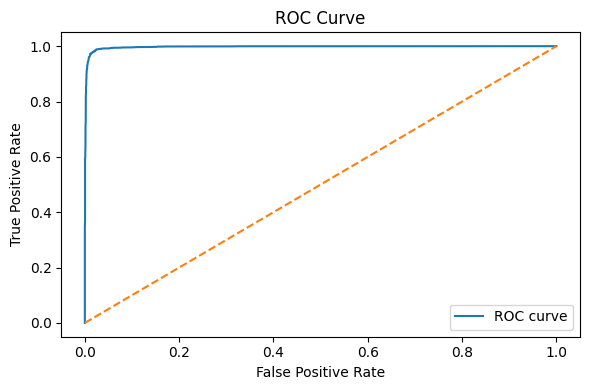

In [6]:
# ROC curve
if y_true is not None:
    fpr, tpr, _ = roc_curve(y_true[mask], y_score[mask])
    fig = plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label="ROC curve")
    plt.plot([0,1], [0,1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


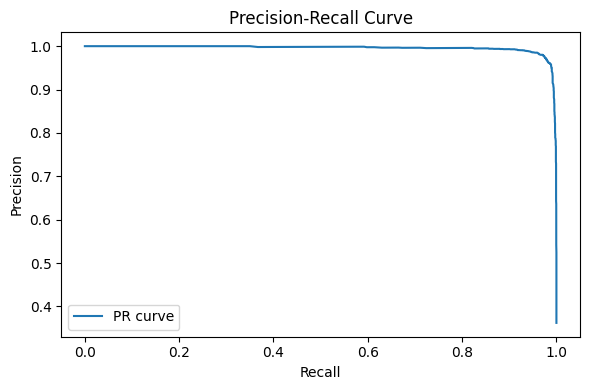

In [7]:
# PR curve
if y_true is not None:
    prec, rec, _ = precision_recall_curve(y_true[mask], y_score[mask])
    fig = plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label="PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


Class balance:
 koi_disposition
FALSE POSITIVE    4838
PLANET            2746
Name: count, dtype: int64


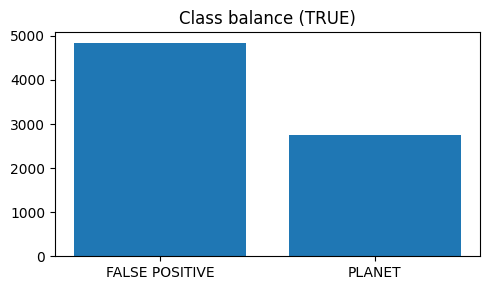

In [8]:
# Class balance (true labels)
if y_true is not None:
    counts = pd.Series(y_true_raw[mask]).value_counts().reindex(["FALSE POSITIVE","PLANET"], fill_value=0)
    print("Class balance:\n", counts)
    fig = plt.figure(figsize=(5,3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title("Class balance (TRUE)")
    plt.tight_layout()
    plt.show()


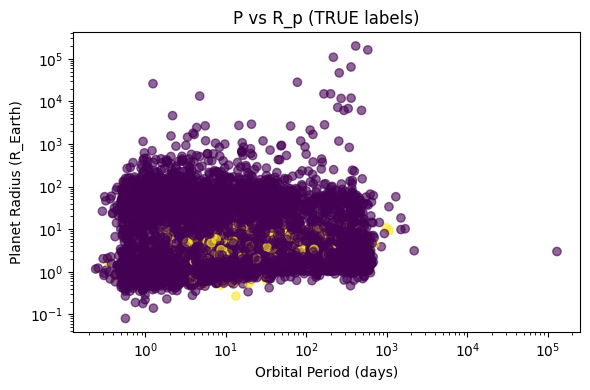

In [9]:
# P vs R_p portrait (TRUE labels)
if label_col is not None and {'koi_period','koi_prad'}.issubset(df.columns):
    fig = plt.figure(figsize=(6,4))
    x = pd.to_numeric(df['koi_period'], errors='coerce')
    y = pd.to_numeric(df['koi_prad'], errors='coerce')
    m = np.isfinite(x) & np.isfinite(y)
    if y_true is not None:
        cls = y_true.replace({0:0,1:1})
        plt.scatter(x[m], y[m], c=cls[m], alpha=0.6)
    else:
        plt.scatter(x[m], y[m], alpha=0.6)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Orbital Period (days)')
    plt.ylabel('Planet Radius (R_Earth)')
    plt.title('P vs R_p (TRUE labels)')
    plt.tight_layout()
    plt.show()


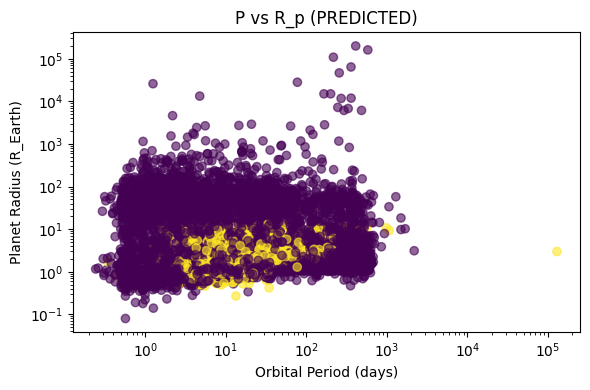

In [10]:
# P vs R_p portrait (PREDICTED)
if {'koi_period','koi_prad'}.issubset(df.columns):
    fig = plt.figure(figsize=(6,4))
    x = pd.to_numeric(df['koi_period'], errors='coerce')
    y = pd.to_numeric(df['koi_prad'], errors='coerce')
    m = np.isfinite(x) & np.isfinite(y)
    plt.scatter(x[m], y[m], c=y_pred[m], alpha=0.6)
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Orbital Period (days)')
    plt.ylabel('Planet Radius (R_Earth)')
    plt.title('P vs R_p (PREDICTED)')
    plt.tight_layout()
    plt.show()


C:\Users\HOME\AppData\Local\Temp\ipykernel_21908\1406869461.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g1, g0], labels=['PLANET','FALSE POSITIVE'], showfliers=False)


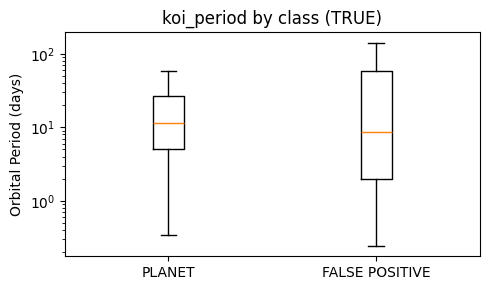

C:\Users\HOME\AppData\Local\Temp\ipykernel_21908\1406869461.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g1, g0], labels=['PLANET','FALSE POSITIVE'], showfliers=False)


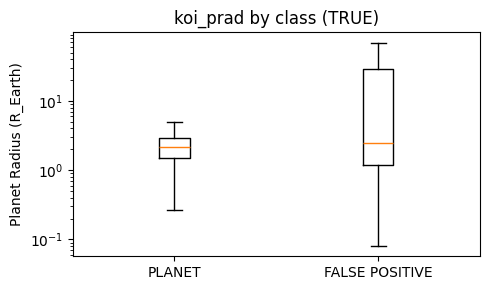

C:\Users\HOME\AppData\Local\Temp\ipykernel_21908\1406869461.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g1, g0], labels=['PLANET','FALSE POSITIVE'], showfliers=False)


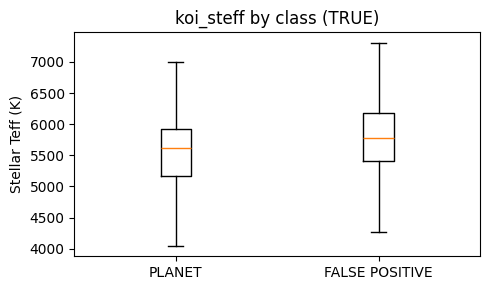

In [11]:
# Boxplots by TRUE class
def _boxplot_by_class(col, label, logy=False):
    if (label_col is None) or (col not in df.columns):
        return
    g1 = pd.to_numeric(df.loc[(y_true==1), col], errors='coerce') if y_true is not None else None
    g0 = pd.to_numeric(df.loc[(y_true==0), col], errors='coerce') if y_true is not None else None
    if g1 is None or g0 is None:
        return
    g1 = g1[np.isfinite(g1)]; g0 = g0[np.isfinite(g0)]
    fig = plt.figure(figsize=(5,3))
    plt.boxplot([g1, g0], labels=['PLANET','FALSE POSITIVE'], showfliers=False)
    if logy: plt.yscale('log')
    plt.ylabel(label); plt.title(f"{col} by class (TRUE)")
    plt.tight_layout(); plt.show()

_boxplot_by_class('koi_period', 'Orbital Period (days)', logy=True)
_boxplot_by_class('koi_prad',   'Planet Radius (R_Earth)', logy=True)
_boxplot_by_class('koi_steff',  'Stellar Teff (K)', logy=False)
